/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/001
['/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/001/IMG_0232_2.tif', '/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/001/IMG_0232_1.tif', '/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/001/IMG_0232_3.tif', '/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/001/IMG_0232_5.tif', '/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/001/IMG_0232_4.tif']


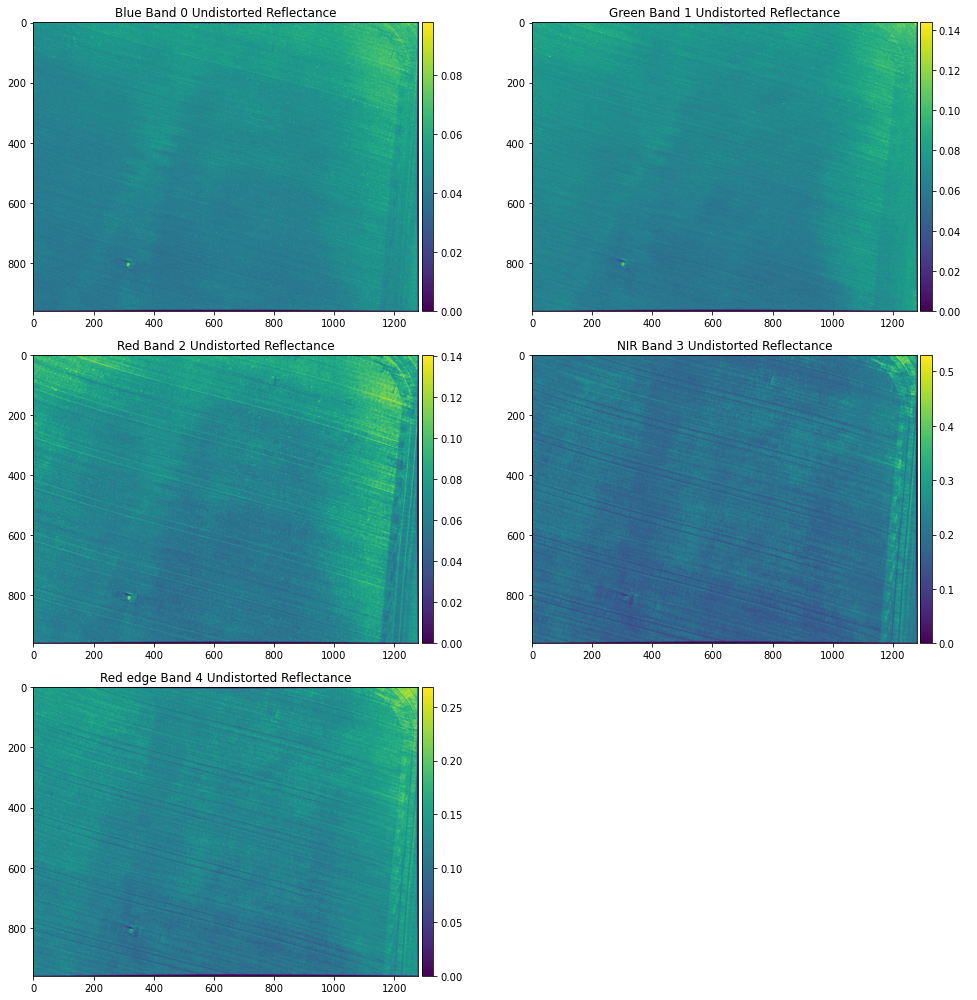

In [7]:
import os, glob
import micasense.capture as capture
%matplotlib inline

panelNames = None

# # This is an older RedEdge image without RigRelatives
# imagePath = os.path.join(os.path.abspath('.'),'data','0000SET','000')
# imageNames = glob.glob(os.path.join(imagePath,'IMG_0001_*.tif'))
# panelNames = glob.glob(os.path.join(imagePath,'IMG_0000_*.tif'))



# # Image from the example RedEdge imageSet (see the ImageSet notebook) without RigRelatives.
# imagePath = os.path.expanduser(os.path.join('/home/cvg-ws05/msi_up/nikhil/MSI/data/DataCapture/agri_data_30jul','0021SET'))
# imageNames = glob.glob(os.path.join(imagePath,'000','IMG_0005_*.tif'))  # sets to be aligned
# panelNames = glob.glob(os.path.join(imagePath,'000','IMG_0000_*.tif'))  # corresponding CRP images for metadata


# Image from the example RedEdge imageSet (see the ImageSet notebook) without RigRelatives.
imagePath = os.path.expanduser(os.path.join('/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1','001'))
imagePath_panel = os.path.expanduser(os.path.join('/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1','000'))
imageNames = glob.glob(os.path.join(imagePath,'IMG_0232_*.tif'))  # sets to be aligned
panelNames = glob.glob(os.path.join(imagePath_panel,'IMG_0000_*.tif'))  # corresponding CRP images for metadata




# This is an altum image with RigRelatives and a thermal band
# imagePath = os.path.join('.','data','ALTUM1SET','000')
# imageNames = glob.glob(os.path.join(imagePath,'IMG_0245_*.tif'))
# panelNames = glob.glob(os.path.join(imagePath,'IMG_0000_*.tif'))


# Allow this code to align both radiance and reflectance images; bu excluding
# a definition for panelNames above, radiance images will be used
# For panel images, efforts will be made to automatically extract the panel information
# but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
# will need to be set in the panel_reflectance_by_band variable.
# Note: radiance images will not be used to properly create NDVI/NDRE images below.
if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)

else:
    panelCap = None

print(imagePath)
print(imageNames)
capture = capture.Capture.from_filelist(imageNames)

if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
    capture.plot_undistorted_reflectance(panel_irradiance)
else:
    if capture.dls_present():
        img_type='reflectance'
        capture.plot_undistorted_reflectance(capture.dls_irradiance())
    else:
        img_type = "radiance"
        capture.plot_undistorted_radiance()    

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

## Alignment settings
match_index = 1 # Index of the band 
max_alignment_iterations = 20
warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY
pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment

print("Alinging images. Depending on settings this can take from a few seconds to many minutes")
# Can potentially increase max_iterations for better results, but longer runtimes
warp_matrices, alignment_pairs = imageutils.align_capture(capture,
                                                          ref_index = match_index,
                                                          max_iterations = max_alignment_iterations,
                                                          warp_mode = warp_mode,
                                                          pyramid_levels = pyramid_levels)

print("Finished Aligning, warp matrices={}".format(warp_matrices))



Alinging images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1
Finished aligning band 0
Finished aligning band 4
Finished aligning band 2
Finished aligning band 3
Finished Aligning, warp matrices=[array([[ 9.9815249e-01,  3.9253705e-03,  1.0611655e+01],
       [-6.4480929e-03,  9.9781418e-01,  3.0467510e+00],
       [-1.8784268e-06, -2.5353522e-06,  1.0000000e+00]], dtype=float32), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32), array([[ 1.0001944e+00,  4.2686806e-05,  1.6422396e+01],
       [-5.8512297e-04,  9.9991208e-01,  5.4591928e+00],
       [-1.0173626e-06, -2.6169013e-07,  1.0000000e+00]], dtype=float32), array([[ 1.0010735e+00,  1.8419720e-03,  8.4927511e+00],
       [-5.6889057e-03,  1.0006176e+00,  5.0981765e+00],
       [-2.5054621e-06, -4.1886356e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0023689e+00,  2.2157580e-03,  2.1057667e+01],
       [-3.5627391e-03,  9.9968594e-01,  5.6242232e+

In [9]:
cropped_dimensions, edges = imageutils.find_crop_bounds(capture, warp_matrices, warp_mode=warp_mode)
im_aligned = imageutils.aligned_capture(capture, warp_matrices, warp_mode, cropped_dimensions, match_index, img_type=img_type)

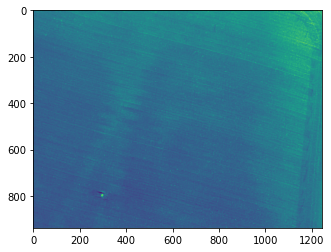

In [10]:
plt.imshow(im_aligned[:,:,0])
# plt.savefig('chnl_4.png')

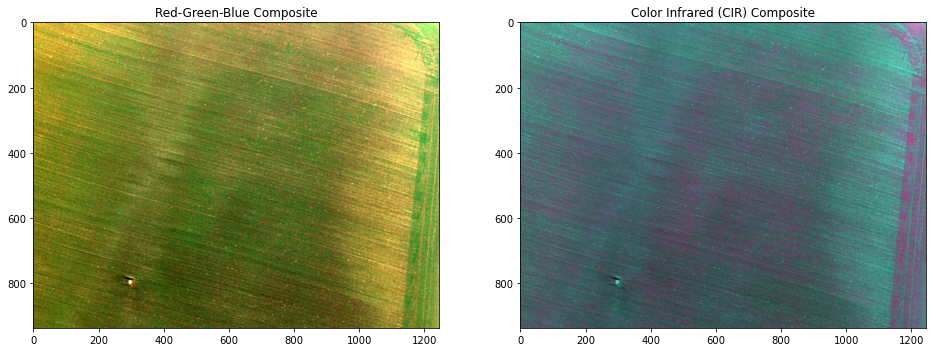

In [11]:
# figsize=(30,23) # use this size for full-image-resolution display
figsize=(16,13)   # use this size for export-sized display

rgb_band_indices = [capture.band_names_lower().index('red'),
                    capture.band_names_lower().index('green'),
                    capture.band_names_lower().index('blue')]
cir_band_indices = [capture.band_names_lower().index('nir'),
                    capture.band_names_lower().index('red'),
                    capture.band_names_lower().index('green')]

# Create a normalized stack for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],im_aligned.shape[2]), dtype=np.float32 )

im_min = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 0.5)  # modify these percentiles to adjust contrast
im_max = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values

# for rgb true color, we use the same min and max scaling across the 3 bands to 
# maintain the "white balance" of the calibrated image
for i in rgb_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)

rgb = im_display[:,:,rgb_band_indices]

# for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
# the classical CIR rendering where plants are red and soil takes on a blue tint
for i in cir_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

cir = im_display[:,:,cir_band_indices]
fig, axes = plt.subplots(1, 2, figsize=figsize)
axes[0].set_title("Red-Green-Blue Composite")
axes[0].imshow(rgb)
axes[1].set_title("Color Infrared (CIR) Composite")
axes[1].imshow(cir)
plt.show()

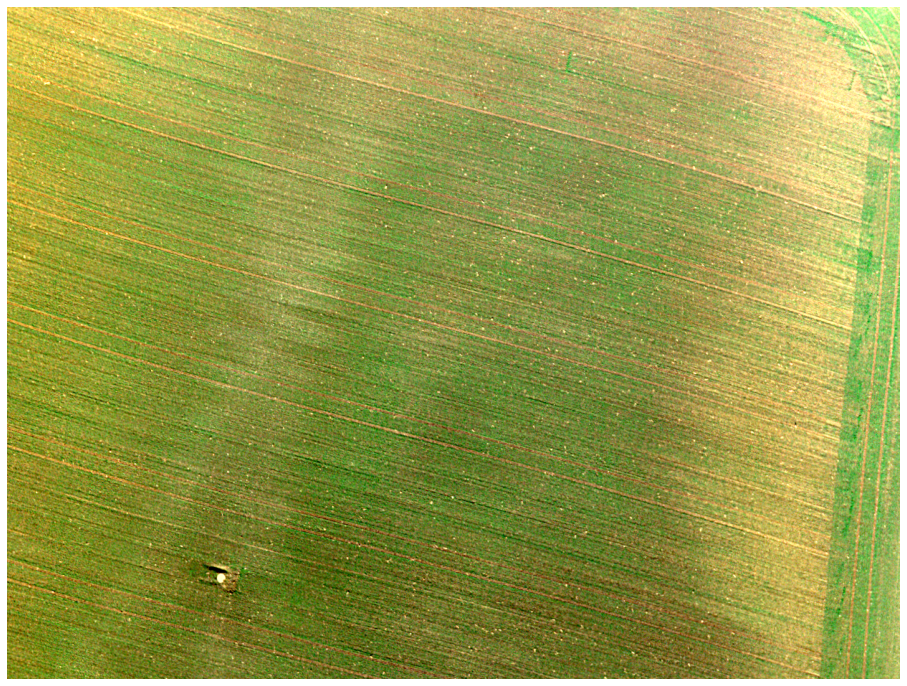

In [12]:
# Create an enhanced version of the RGB render using an unsharp mask
gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
gaussian_rgb[gaussian_rgb<0] = 0
gaussian_rgb[gaussian_rgb>1] = 1
unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
unsharp_rgb[unsharp_rgb<0] = 0
unsharp_rgb[unsharp_rgb>1] = 1

# Apply a gamma correction to make the render appear closer to what our eyes would see
gamma = 1.4
gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
fig = plt.figure(figsize=figsize)
plt.imshow(gamma_corr_rgb, aspect='equal')
plt.axis('off')
plt.show()

# NDVI map generation


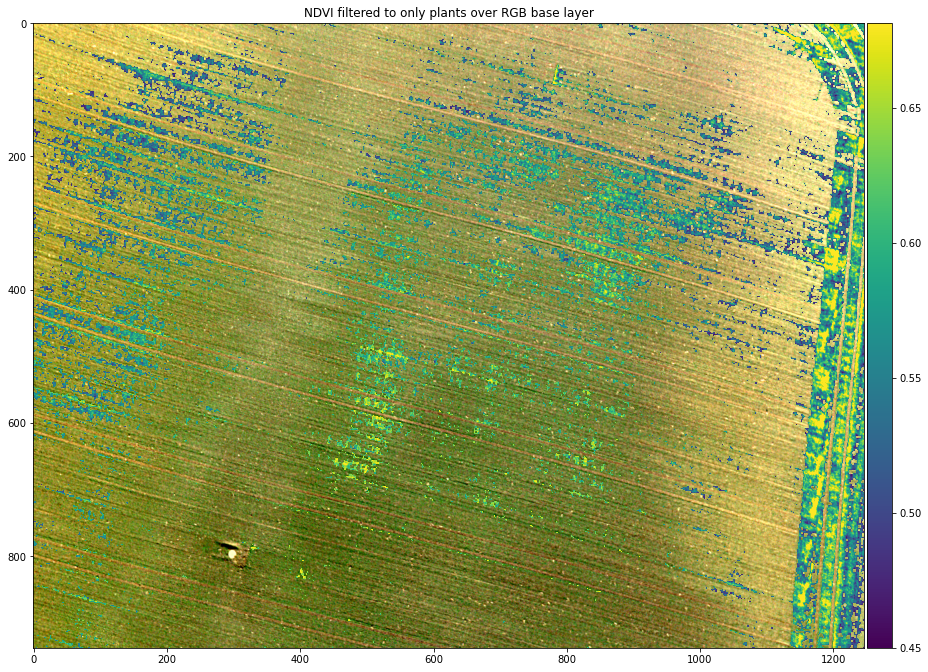

In [13]:
from micasense import plotutils
import matplotlib.pyplot as plt

nir_band = capture.band_names_lower().index('nir')
red_band = capture.band_names_lower().index('red')

np.seterr(divide='ignore', invalid='ignore') # ignore divide by zero errors in the index calculation

# Compute Normalized Difference Vegetation Index (NDVI) from the NIR(3) and RED (2) bands
ndvi = (im_aligned[:,:,nir_band] - im_aligned[:,:,red_band]) / (im_aligned[:,:,nir_band] + im_aligned[:,:,red_band])

# remove shadowed areas (mask pixels with NIR reflectance < 20%))
if img_type == 'reflectance':
    ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] < 0.20, ndvi) 
elif img_type == 'radiance':
    lower_pct_radiance = np.percentile(im_aligned[:,:,3],  10.0)
    ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] < lower_pct_radiance, ndvi) 
    
# Compute and display a histogram
ndvi_hist_min = np.min(ndvi)
ndvi_hist_max = np.max(ndvi)
fig, axis = plt.subplots(1, 1, figsize=(10,4))
axis.hist(ndvi.ravel(), bins=512, range=(ndvi_hist_min, ndvi_hist_max))
plt.title("NDVI Histogram")
plt.show()

min_display_ndvi = 0.45 # further mask soil by removing low-ndvi values
#min_display_ndvi = np.percentile(ndvi.flatten(),  5.0)  # modify with these percentilse to adjust contrast
max_display_ndvi = np.percentile(ndvi.flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values
masked_ndvi = np.ma.masked_where(ndvi < min_display_ndvi, ndvi)

#reduce the figure size to account for colorbar
figsize=np.asarray(figsize) - np.array([3,2])

#plot NDVI over an RGB basemap, with a colorbar showing the NDVI scale
fig, axis = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb, 
                                    masked_ndvi, 
                                    figsize = figsize, 
                                    title = 'NDVI filtered to only plants over RGB base layer',
                                    vmin = min_display_ndvi,
                                    vmax = max_display_ndvi)
fig.savefig('ndvi_over_rgb.png')